In [1]:
# You should not use any imports not listed here:
from collections import Counter, defaultdict, deque
import copy
import math
import networkx as nx
import urllib.request

In [2]:
## Community Detection

def example_graph():
    """
    Create the example graph from class. Used for testing.
    Do not modify.
    """
    g = nx.Graph()
    g.add_edges_from([('A', 'B'), ('A', 'C'), ('B', 'C'), ('B', 'D'), ('D', 'E'), ('D', 'F'), ('D', 'G'), ('E', 'F'), ('G', 'F')])
    return g

In [3]:
def bfs(graph, root, max_depth):
    """
    Perform breadth-first search to compute the shortest paths from a root node to all
    other nodes in the graph. To reduce running time, the max_depth parameter ends
    the search after the specified depth.
    E.g., if max_depth=2, only paths of length 2 or less will be considered.
    This means that nodes greather than max_depth distance from the root will not
    appear in the result.

    You may use these two classes to help with this implementation:
      https://docs.python.org/3.5/library/collections.html#collections.defaultdict
      https://docs.python.org/3.5/library/collections.html#collections.deque

    Params:
      graph.......A networkx Graph
      root........The root node in the search graph (a string). We are computing
                  shortest paths from this node to all others.
      max_depth...An integer representing the maximum depth to search.

    Returns:
      node2distances...dict from each node to the length of the shortest path from
                       the root node
      node2num_paths...dict from each node to the number of shortest paths from the
                       root node that pass through this node.
      node2parents.....dict from each node to the list of its parents in the search
                       tree

    In the doctests below, we first try with max_depth=5, then max_depth=2.

    >>> node2distances, node2num_paths, node2parents = bfs(example_graph(), 'E', 5)
    >>> sorted(node2distances.items())
    [('A', 3), ('B', 2), ('C', 3), ('D', 1), ('E', 0), ('F', 1), ('G', 2)]
    >>> sorted(node2num_paths.items())
    [('A', 1), ('B', 1), ('C', 1), ('D', 1), ('E', 1), ('F', 1), ('G', 2)]
    >>> sorted((node, sorted(parents)) for node, parents in node2parents.items())
    [('A', ['B']), ('B', ['D']), ('C', ['B']), ('D', ['E']), ('F', ['E']), ('G', ['D', 'F'])]
    >>> node2distances, node2num_paths, node2parents = bfs(example_graph(), 'E', 2)
    >>> sorted(node2distances.items())
    [('B', 2), ('D', 1), ('E', 0), ('F', 1), ('G', 2)]
    >>> sorted(node2num_paths.items())
    [('B', 1), ('D', 1), ('E', 1), ('F', 1), ('G', 2)]
    >>> sorted((node, sorted(parents)) for node, parents in node2parents.items())
    [('B', ['D']), ('D', ['E']), ('F', ['E']), ('G', ['D', 'F'])]
    """
    ###TODO
    node2distances = {root:0}
    node2num_paths = defaultdict(lambda :0)
    node2parents = defaultdict(lambda :[])
    queue = deque([root])
#     print (node2distances[root])
    node2distances[root] = 0
    # do bfs
    
    while len(queue)>0 :
        node = queue.popleft()
        if node2distances[node] >= max_depth:
            break
        for neighbor in graph.neighbors(node):
            if neighbor not in node2distances:
                if node2distances[node] +1 <= max_depth:
                    queue.append(neighbor)
                    node2distances[neighbor] = node2distances[node]+1
            
            if node2distances[neighbor] == node2distances[node]+1:
                node2parents[neighbor].append(node)
                node2num_paths[neighbor] = node2num_paths[neighbor]+1
    node2num_paths[root] = 1
    return node2distances, dict(node2num_paths), dict(node2parents)

    pass

In [4]:
    >>> node2distances, node2num_paths, node2parents = bfs(example_graph(), 'E', 2)
    >>> sorted(node2distances.items())
#     [('B', 2), ('D', 1), ('E', 0), ('F', 1), ('G', 2)]

[('B', 2), ('D', 1), ('E', 0), ('F', 1), ('G', 2)]

In [5]:
>>> sorted(node2num_paths.items())
#     [('B', 1), ('D', 1), ('E', 1), ('F', 1), ('G', 2)]

[('B', 1), ('D', 1), ('E', 1), ('F', 1), ('G', 2)]

In [6]:
    >>> node2distances, node2num_paths, node2parents = bfs(example_graph(), 'E', 5)
    >>> sorted(node2distances.items())

[('A', 3), ('B', 2), ('C', 3), ('D', 1), ('E', 0), ('F', 1), ('G', 2)]

In [7]:
sorted(node2distances.items(), key=lambda x: -x[1])

[('C', 3), ('A', 3), ('B', 2), ('G', 2), ('F', 1), ('D', 1), ('E', 0)]

In [8]:
>>> sorted(node2num_paths.items())

[('A', 1), ('B', 1), ('C', 1), ('D', 1), ('E', 1), ('F', 1), ('G', 2)]

In [9]:
sorted((node, sorted(parents)) for node, parents in node2parents.items())

[('A', ['B']),
 ('B', ['D']),
 ('C', ['B']),
 ('D', ['E']),
 ('F', ['E']),
 ('G', ['D', 'F'])]

In [10]:
type(node2parents)

dict

In [11]:
def bottom_up(root, node2distances, node2num_paths, node2parents):
    """
    Compute the final step of the Girvan-Newman algorithm.
    See p 352 From your text:
    https://github.com/iit-cs579/main/blob/master/read/lru-10.pdf
        The third and final step is to calculate for each edge e the sum
        over all nodes Y of the fraction of shortest paths from the root
        X to Y that go through e. This calculation involves computing this
        sum for both nodes and edges, from the bottom. Each node other
        than the root is given a credit of 1, representing the shortest
        path to that node. This credit may be divided among nodes and
        edges above, since there could be several different shortest paths
        to the node. The rules for the calculation are as follows: ...

    Params:
      root.............The root node in the search graph (a string). We are computing
                       shortest paths from this node to all others.
      node2distances...dict from each node to the length of the shortest path from
                       the root node
      node2num_paths...dict from each node to the number of shortest paths from the
                       root node that pass through this node.
      node2parents.....dict from each node to the list of its parents in the search
                       tree
    Returns:
      A dict mapping edges to credit value. Each key is a tuple of two strings
      representing an edge (e.g., ('A', 'B')). Make sure each of these tuples
      are sorted alphabetically (so, it's ('A', 'B'), not ('B', 'A')).

      Any edges excluded from the results in bfs should also be exluded here.

    >>> node2distances, node2num_paths, node2parents = bfs(example_graph(), 'E', 5)
    >>> result = bottom_up('E', node2distances, node2num_paths, node2parents)
    >>> sorted(result.items())
    [(('A', 'B'), 1.0), (('B', 'C'), 1.0), (('B', 'D'), 3.0), (('D', 'E'), 4.5), (('D', 'G'), 0.5), (('E', 'F'), 1.5), (('F', 'G'), 0.5)]
    """
    ###TODO
    # get leaf nodes
    node2credit = defaultdict(lambda :0)
    credit = defaultdict(lambda:0)
    parents = [item for sublist in node2parents.values() for item in sublist]
    for n in node2distances:
        if n not in parents:
            node2credit[n] = 1
#     print( 'leaf: ',node2credit.items())
    levels = sorted(node2distances.items(), key=lambda x: -x[1])
#     print ('levels:', levels)
    for c,_ in levels:
        if c is root:
            break
        ps = node2parents[c]
#         print(ps)
        if root in ps:
            l = sorted([c,root])
            credit[(l[0], l[1])] = node2credit[c]
        else:
            s = sum(node2num_paths[i] for i in ps)
            for p in ps:
                l = sorted([c,p])
                edge = (l[0], l[1])
                credit[edge]  = node2credit[c]*node2num_paths[p]/s
                node2credit[p]+= credit[edge]
                parents.remove(p)
                if p not in parents:
                    node2credit[p] += 1

    return dict(credit)

In [12]:
    >>> node2distances, node2num_paths, node2parents = bfs(example_graph(), 'E', 5)
    >>> result = bottom_up('E', node2distances, node2num_paths, node2parents)
    >>> sorted(result.items())

[(('A', 'B'), 1.0),
 (('B', 'C'), 1.0),
 (('B', 'D'), 3.0),
 (('D', 'E'), 4.5),
 (('D', 'G'), 0.5),
 (('E', 'F'), 1.5),
 (('F', 'G'), 0.5)]

[(('A', 'B'), 1.0), (('B', 'C'), 1.0), (('B', 'D'), 3.0), (('D', 'E'), 4.5), (('D', 'G'), 0.5), (('E', 'F'), 1.5), (('F', 'G'), 0.5)]

In [13]:
def approximate_betweenness(graph, max_depth):
    """
    Compute the approximate betweenness of each edge, using max_depth to reduce
    computation time in breadth-first search.

    You should call the bfs and bottom_up functions defined above for each node
    in the graph, and sum together the results. Be sure to divide by 2 at the
    end to get the final betweenness.

    Params:
      graph.......A networkx Graph
      max_depth...An integer representing the maximum depth to search.

    Returns:
      A dict mapping edges to betweenness. Each key is a tuple of two strings
      representing an edge (e.g., ('A', 'B')). Make sure each of these tuples
      are sorted alphabetically (so, it's ('A', 'B'), not ('B', 'A')).

    >>> sorted(approximate_betweenness(example_graph(), 2).items())
    [(('A', 'B'), 2.0), (('A', 'C'), 1.0), (('B', 'C'), 2.0), (('B', 'D'), 6.0), (('D', 'E'), 2.5), (('D', 'F'), 2.0), (('D', 'G'), 2.5), (('E', 'F'), 1.5), (('F', 'G'), 1.5)]
    """
    ###TODO
    btn = defaultdict(lambda: 0)
    for n in graph.nodes():
        node2distances, node2num_paths, node2parents = bfs(graph, n, max_depth)
        result = bottom_up(n, node2distances, node2num_paths, node2parents)
#         print (n,': ',result.values())
        for key in result:
            btn[key] += result[key]/2
#     print(btn.items())
    return dict(btn)        
    pass

In [14]:
>>> sorted(approximate_betweenness(example_graph(),2).items(), key = lambda x: x[1])

[(('A', 'C'), 1.0),
 (('E', 'F'), 1.5),
 (('F', 'G'), 1.5),
 (('B', 'C'), 2.0),
 (('D', 'F'), 2.0),
 (('A', 'B'), 2.0),
 (('D', 'E'), 2.5),
 (('D', 'G'), 2.5),
 (('B', 'D'), 6.0)]

In [15]:
sorted(approximate_betweenness(example_graph(), 2).items())

[(('A', 'B'), 2.0),
 (('A', 'C'), 1.0),
 (('B', 'C'), 2.0),
 (('B', 'D'), 6.0),
 (('D', 'E'), 2.5),
 (('D', 'F'), 2.0),
 (('D', 'G'), 2.5),
 (('E', 'F'), 1.5),
 (('F', 'G'), 1.5)]

In [16]:
def is_approximation_always_right():
    """
    Look at the doctests for approximate betweenness. In this example, the
    edge with the highest betweenness was ('B', 'D') for both cases (when
    max_depth=5 and max_depth=2).

    Consider an arbitrary graph G. For all max_depth > 1, will it always be
    the case that the edge with the highest betweenness will be the same
    using either approximate_betweenness verses the exact computation?
    Answer this question below.

    In this function, you just need to return either the string 'yes' or 'no'
    (no need to do any actual computations here).
    >>> s = is_approximation_always_right()
    >>> type(s)
    <class 'str'>
    """
    ###TODO
    return 'no'
    pass

In [17]:
def partition_girvan_newman(graph, max_depth):
    """
    Use your approximate_betweenness implementation to partition a graph.
    Unlike in class, here you will not implement this recursively. Instead,
    just remove edges until more than one component is created, then return
    those components.
    That is, compute the approximate betweenness of all edges, and remove
    them until multiple comonents are created.

    You only need to compute the betweenness once.
    If there are ties in edge betweenness, break by edge name (e.g.,
    (('A', 'B'), 1.0) comes before (('B', 'C'), 1.0)).

    Note: the original graph variable should not be modified. Instead,
    make a copy of the original graph prior to removing edges.
    See the Graph.copy method https://networkx.github.io/documentation/development/reference/generated/networkx.Graph.copy.html
    Params:
      graph.......A networkx Graph
      max_depth...An integer representing the maximum depth to search.

    Returns:
      A list of networkx Graph objects, one per partition.

    >>> components = partition_girvan_newman(example_graph(), 5)
    >>> components = sorted(components, key=lambda x: sorted(x.nodes())[0])
    >>> sorted(components[0].nodes())
    ['A', 'B', 'C']
    >>> sorted(components[1].nodes())
    ['D', 'E', 'F', 'G']
    """
    
#     ###TODO
#     components = []
#     lists = sorted(approximate_betweenness(graph, max_depth).items(), key = lambda x: x[1], reverse=True)
#     for e,_ in lists:
#         graph.remove_edge(*e)
#         graphs = list(nx.connected_component_subgraphs(graph))
#         if len(graphs) > 1:
#             for g in graphs:
#                 components.append(g)
#             break
#     return components
#     pass

    if graph.order() == 1:
        return [graph.nodes()]

    g = graph.copy()
    lists = sorted(approximate_betweenness(g, max_depth).items(), key=lambda x: -x[1])
    components = [c for c in nx.connected_component_subgraphs(g)]
    i = 0
    while len(components) == 1:
        e = lists[i][0]
        # print(e)
        g.remove_edge(*e)
        components = [c for c in nx.connected_component_subgraphs(g)]
        i += 1
    return components
    pass

In [18]:
    >>> components = partition_girvan_newman(example_graph(), 6)
    >>> components = sorted(components, key=lambda x: sorted(x.nodes())[0])
#     >>> len(components)
    >>> sorted(components[0].nodes())

['A', 'B', 'C']

In [19]:
    >>> sorted(components[1].nodes())

['D', 'E', 'F', 'G']

In [20]:
def get_subgraph(graph, min_degree):
    """Return a subgraph containing nodes whose degree is
    greater than or equal to min_degree.
    We'll use this in the main method to prune the original graph.

    Params:
      graph........a networkx graph
      min_degree...degree threshold
    Returns:
      a networkx graph, filtered as defined above.

    >>> subgraph = get_subgraph(example_graph(), 3)
    >>> sorted(subgraph.nodes())
    ['B', 'D', 'F']
    >>> len(subgraph.edges())
    2
    """
    ###TODO
    nodes = [n for n in graph.nodes() if graph.degree(n) >= min_degree]
    subgraph = graph.subgraph(nodes)
    return subgraph
    pass


In [21]:
    >>> subgraph = get_subgraph(example_graph(), 3)
    >>> sorted(subgraph.nodes())

['B', 'D', 'F']

In [22]:
    >>> len(subgraph.edges())

2

In [23]:
""""
Compute the normalized cut for each discovered cluster.
I've broken this down into the three next methods.
"""

def volume(nodes, graph):
    """
    Compute the volume for a list of nodes, which
    is the number of edges in `graph` with at least one end in
    nodes.
    Params:
      nodes...a list of strings for the nodes to compute the volume of.
      graph...a networkx graph

    >>> volume(['A', 'B', 'C'], example_graph())
    4
    """
    ###TODO    
    s = sum(d for v, d in graph.degree(nodes).items())
    ne = nx.number_of_edges(graph.subgraph(nodes))
    return s-ne
    pass

In [24]:
    >>> volume(['A', 'B', 'C'], example_graph())

4

In [25]:

def cut(S, T, graph):
    """
    Compute the cut-set of the cut (S,T), which is
    the set of edges that have one endpoint in S and
    the other in T.
    Params:
      S.......set of nodes in first subset
      T.......set of nodes in second subset
      graph...networkx graph
    Returns:
      An int representing the cut-set.

    >>> cut(['A', 'B', 'C'], ['D', 'E', 'F', 'G'], example_graph())
    1
    """
    ###TODO
    totalD = nx.number_of_edges(graph)
    return volume(S,graph)+volume(T,graph)-totalD
    pass


In [26]:
>>> cut(['A', 'B', 'C'], ['D', 'E', 'F', 'G'], example_graph())

1

In [27]:
def norm_cut(S, T, graph):
    """
    The normalized cut value for the cut S/T. (See lec06.)
    Params:
      S.......set of nodes in first subset
      T.......set of nodes in second subset
      graph...networkx graph
    Returns:
      An float representing the normalized cut value

    """
    ###TODO
    c = cut(S,T,graph)
    norm = c/float(volume(S,graph))+c/float(volume(T,graph))
    return norm
    pass


def score_max_depths(graph, max_depths):
    """
    In order to assess the quality of the approximate partitioning method
    we've developed, we will run it with different values for max_depth
    and see how it affects the norm_cut score of the resulting partitions.
    Recall that smaller norm_cut scores correspond to better partitions.

    Params:
      graph........a networkx Graph
      max_depths...a list of ints for the max_depth values to be passed
                   to calls to partition_girvan_newman

    Returns:
      A list of (int, float) tuples representing the max_depth and the
      norm_cut value obtained by the partitions returned by
      partition_girvan_newman. See Log.txt for an example.
    """
#     ###TODO
    score = []
    g = graph.copy()
    for md in max_depths:
        subgraphs = partition_girvan_newman(g, md)
        score.append((md, norm_cut(subgraphs[0], subgraphs[1], g)))
        g = graph.copy()

    return score
    pass

In [28]:
score_max_depths(example_graph(), range(1,5))

[(1, 1.0285714285714285),
 (2, 0.41666666666666663),
 (3, 0.41666666666666663),
 (4, 0.41666666666666663)]

In [29]:
## Link prediction

# Next, we'll consider the link prediction problem. In particular,
# we will remove 5 of the accounts that Bill Gates likes and
# compute our accuracy at recovering those links.

def make_training_graph(graph, test_node, n):
    """
    To make a training graph, we need to remove n edges from the graph.
    As in lecture, we'll assume there is a test_node for which we will
    remove some edges. Remove the edges to the first n neighbors of
    test_node, where the neighbors are sorted alphabetically.
    E.g., if 'A' has neighbors 'B' and 'C', and n=1, then the edge
    ('A', 'B') will be removed.

    Be sure to *copy* the input graph prior to removing edges.

    Params:
      graph.......a networkx Graph
      test_node...a string representing one node in the graph whose
                  edges will be removed.
      n...........the number of edges to remove.

    Returns:
      A *new* networkx Graph with n edges removed.

    In this doctest, we remove edges for two friends of D:
    >>> g = example_graph()
    >>> sorted(g.neighbors('D'))
    ['B', 'E', 'F', 'G']
    >>> train_graph = make_training_graph(g, 'D', 2)
    >>> sorted(train_graph.neighbors('D'))
    ['F', 'G']
    """
    ###TODO
    g = graph.copy()
    nb = sorted(g.neighbors(test_node))
    for i in range(min(len(nb),n)):
        g.remove_edge(test_node,nb[i])
    return g
    pass

In [30]:
    >>> g = example_graph()
    >>> sorted(g.neighbors('D'))
#     ['B', 'E', 'F', 'G']


['B', 'E', 'F', 'G']

In [31]:
    >>> train_graph = make_training_graph(g, 'D', 2)
    >>> sorted(train_graph.neighbors('D'))
#     ['F', 'G']


['F', 'G']

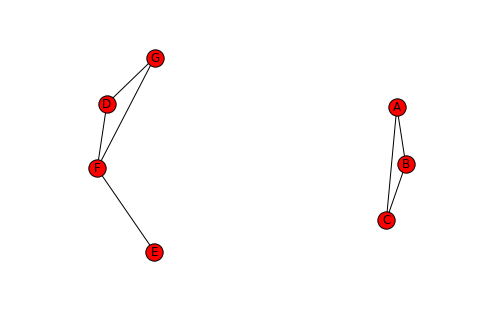

In [32]:
%matplotlib inline 
import matplotlib.pyplot as plt
nx.draw(train_graph, with_labels=True)

In [33]:

def jaccard(graph, node, k):
    """
    Compute the k highest scoring edges to add to this node based on
    the Jaccard similarity measure.
    Note that we don't return scores for edges that already appear in the graph.

    Params:
      graph....a networkx graph
      node.....a node in the graph (a string) to recommend links for.
      k........the number of links to recommend.

    Returns:
      A list of tuples in descending order of score representing the
      recommended new edges. Ties are broken by
      alphabetical order of the terminal node in the edge.

    In this example below, we remove edges (D, B) and (D, E) from the
    example graph. The top two edges to add according to Jaccard are
    (D, E), with score 0.5, and (D, A), with score 0. (Note that all the
    other remaining edges have score 0, but 'A' is first alphabetically.)

    >>> g = example_graph()
    >>> train_graph = make_training_graph(g, 'D', 2)
    >>> jaccard(train_graph, 'D', 2)
    [(('D', 'E'), 0.5), (('D', 'A'), 0.0)]
    """
    ###TODO
    neighbors = set(graph.neighbors(node))
    scores = []
    for n in sorted(graph.nodes()):
        neighbors2 = set(graph.neighbors(n))
        if node != n and not graph.has_edge(node, n):
            scores.append(((node,n), 1. * len(neighbors & neighbors2) / len(neighbors | neighbors2)))
    return sorted(scores, key=lambda x: x[1], reverse=True)[:k]


[(('D', 'E'), 0.5), (('D', 'A'), 0.0)]


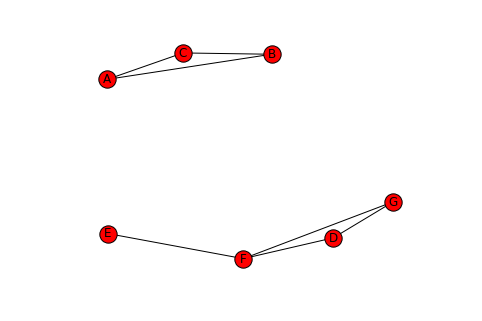

In [34]:
g = example_graph()
train_graph = make_training_graph(g, 'D', 2)

%matplotlib inline 
import matplotlib.pyplot as plt
nx.draw(train_graph, with_labels=True)
print (jaccard(train_graph, 'D', 2))

One limitation of Jaccard is that it only has non-zero values for nodes two hops away.

Implement a new link prediction function that computes the similarity between two nodes $x$ and $y$  as follows:

$$
s(x,y) = \beta^i n_{x,y,i}
$$

where
- $\beta \in [0,1]$ is a user-provided parameter
- $i$ is the length of the shortest path from $x$ to $y$
- $n_{x,y,i}$ is the number of shortest paths between $x$ and $y$ with length $i$

In [41]:
def path_score(graph, root, k, beta):
    """
    Compute a new link prediction scoring function based on the shortest
    paths between two nodes, as defined above.

    Note that we don't return scores for edges that already appear in the graph.

    This algorithm should have the same time complexity as bfs above.

    Params:
      graph....a networkx graph
      root.....a node in the graph (a string) to recommend links for.
      k........the number of links to recommend.
      beta.....the beta parameter in the equation above.

    Returns:
      A list of tuples in descending order of score. Ties are broken by
      alphabetical order of the terminal node in the edge.

    In this example below, we remove edge (D, F) from the
    example graph. The top two edges to add according to path_score are
    (D, F), with score 0.5, and (D, A), with score .25. (Note that (D, C)
    is tied with a score of .25, but (D, A) is first alphabetically.)

    >>> g = example_graph()
    >>> train_graph = g.copy()
    >>> train_graph.remove_edge(*('D', 'F'))
    >>> path_score(train_graph, 'D', k=4, beta=.5)
    [(('D', 'F'), 0.5), (('D', 'A'), 0.25), (('D', 'C'), 0.25)]
    """
    ###TODO
    scores = []
    g = graph.copy()
    node2distances, node2num_paths, node2parents = bfs(g, root, math.inf)
    del node2distances[root]
    for node in sorted(node2distances.keys()):
        if not g.has_edge(root, node):
            len_sp = node2distances[node]
            num_path = node2num_paths[node]
            score = math.pow(beta,len_sp)*num_path
            scores.append(((root, node), score))
    return sorted(scores, key = lambda x:-x[1])[:k]
    pass

    

In [42]:
    >>> g = example_graph()
    >>> train_graph = g.copy()
    >>> train_graph.remove_edge(*('D', 'F'))
    >>> path_score(train_graph, 'D', k=4, beta=.5)

[(('D', 'F'), 0.5), (('D', 'A'), 0.25), (('D', 'C'), 0.25)]

In [43]:
def evaluate(predicted_edges, graph):
    """
    Return the fraction of the predicted edges that exist in the graph.

    Args:
      predicted_edges...a list of edges (tuples) that are predicted to
                        exist in this graph
      graph.............a networkx Graph

    Returns:
      The fraction of edges in predicted_edges that exist in the graph.

    In this doctest, the edge ('D', 'E') appears in the example_graph,
    but ('D', 'A') does not, so 1/2 = 0.5

    >>> evaluate([('D', 'E'), ('D', 'A')], example_graph())
    0.5
    """
    ###TODO
    right = 0
    for e in predicted_edges:
        if not graph.has_edge(*e):
            right += 1
    return right/len(predicted_edges)

    pass

In [44]:

"""
Next, we'll download a real dataset to see how our algorithm performs.
"""
def download_data():
    """
    Download the data. Done for you.
    """
    urllib.request.urlretrieve('http://cs.iit.edu/~culotta/cs579/a1/edges.txt.gz', 'edges.txt.gz')


def read_graph():
    """ Read 'edges.txt.gz' into a networkx **undirected** graph.
    Done for you.
    Returns:
      A networkx undirected graph.
    """
    return nx.read_edgelist('edges.txt.gz', delimiter='\t')


def main():
    """
    FYI: This takes ~10-15 seconds to run on my laptop.
    """
    download_data()
    graph = read_graph()
    print('graph has %d nodes and %d edges' %
          (graph.order(), graph.number_of_edges()))
    subgraph = get_subgraph(graph, 2)
    print('subgraph has %d nodes and %d edges' %
          (subgraph.order(), subgraph.number_of_edges()))
    print('norm_cut scores by max_depth:')
    print(score_max_depths(subgraph, range(1,5)))
    clusters = partition_girvan_newman(subgraph, 3)
    print('first partition: cluster 1 has %d nodes and cluster 2 has %d nodes' %
          (clusters[0].order(), clusters[1].order()))
    print('cluster 2 nodes:')
    print(clusters[1].nodes())

    test_node = 'Bill Gates'
    train_graph = make_training_graph(subgraph, test_node, 5)
    print('train_graph has %d nodes and %d edges' %
          (train_graph.order(), train_graph.number_of_edges()))


    jaccard_scores = jaccard(train_graph, test_node, 5)
    print('\ntop jaccard scores for Bill Gates:')
    print(jaccard_scores)
    print('jaccard accuracy=%g' %
          evaluate([x[0] for x in jaccard_scores], subgraph))

    path_scores = path_score(train_graph, test_node, k=5, beta=.1)
    print('\ntop path scores for Bill Gates for beta=.1:')
    print(path_scores[:20])
    print('path accuracy for beta .1=%g' %
          evaluate([x[0] for x in path_scores], subgraph))
if __name__ == '__main__':
    main()


graph has 5062 nodes and 6060 edges
subgraph has 712 nodes and 1710 edges
norm_cut scores by max_depth:
[(1, 1.0005847953216374), (2, 1.0005847953216374), (3, 0.12177725118483412), (4, 0.12177725118483412)]
first partition: cluster 1 has 701 nodes and cluster 2 has 11 nodes
cluster 2 nodes:
['Scholastic Canada', 'Scholastic Parents', 'Scholastic Teachers', 'Scholastic Reading Club', 'The Hunger Games', 'WordGirl', 'Scholastic', 'Scholastic Book Fairs', 'READ 180', 'Arthur A. Levine Books', 'Clifford The Big Red Dog']
train_graph has 712 nodes and 1705 edges

top jaccard scores for Bill Gates:
[(('Bill Gates', 'Global Citizen'), 0.16216216216216217), (('Bill Gates', 'Bill & Melinda Gates Foundation'), 0.10344827586206896), (('Bill Gates', 'Grand Challenges Canada'), 0.09375), (('Bill Gates', 'I fucking love science'), 0.09375), (('Bill Gates', 'Girl Effect'), 0.09090909090909091)]
jaccard accuracy=0.8

top path scores for Bill Gates for beta=.1:
[(('Bill Gates', 'Bill & Melinda Gates Fo